In [43]:
import numpy as np 
import healpy as hp 
from healpy.newvisufunc import projview
import pandas as pd
import matplotlib.pyplot as plt 

from astropy.time import Time 
from astropy.coordinates import EarthLocation
import astropy.units as u

import sys 
import os 

sys.path.append('src/')

from event_manip import time_ordered_events
from event_manip import ang_diff
from event_manip import compute_directional_exposure
from event_manip import get_normalized_exposure_map
from event_manip import get_skymap 
from event_manip import dec_to_colat

%matplotlib inline

#set latex typesetting 
plt.rcParams.update(
{
    'text.usetex' : 'True',
    'font.family' : 'serif'
})

<Figure size 720x576 with 0 Axes>

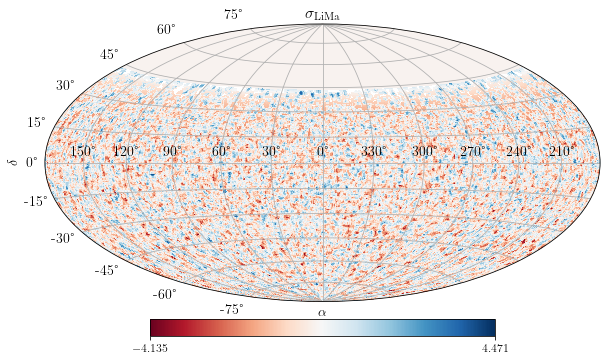

In [44]:
#loads the events from UD
file_path = './datasets/estimators/' 
file_name = 'Scrambled_UniformDist_100000_acceptance_th80_2010-01-01_2020-01-01_9_Estimators.parquet'

if not os.path.exists(file_path + file_name):
    print('File does not exist')
    exit()
    
#save events 
event_data = pd.read_parquet(file_path + file_name, engine='fastparquet')

#event_data = event_data[np.abs(event_data['LiMa_significance']) < 1]

#save declination and right ascension 
dec = np.radians(event_data['dec_center'].to_numpy())
ra = np.radians(event_data['ra_center'].to_numpy())
colat = dec_to_colat(dec)
LiMa_significance = event_data['LiMa_significance'].to_numpy()
 
#deletes dataframe to save space in tmp memory 
#del event_data 

#save number of events 
n_events = len(dec)

#define NSIDE parameter.This must be the same as the one used for computing the significance
NSIDE = 128

#convert angles into pixels 
pixel_indices = hp.ang2pix(NSIDE, colat, ra)

#initalize skymap 
LiMa_skymap = np.zeros(hp.nside2npix(NSIDE))

#add the values of significance to each pixel 
np.add.at(LiMa_skymap, pixel_indices, LiMa_significance)

#mask array 
mask = np.isnan(LiMa_skymap)

LiMa_skymap[np.isnan(LiMa_skymap)] = hp.UNSEEN

LiMa_skymap = hp.ma(LiMa_skymap)

#hp.ma(LiMa_skymap, badval=np.nan)
#LiMa_skymap.mask = np.logical_not(mask)

#define the earth location of the pierre auger observatory 
lat_pao = np.radians(-35.15) # this is the average latitude
long_pao = np.radians(-69.2) # this is the averaga longitude
height_pao = 1425*u.meter # this is the average altitude

pao_loc = EarthLocation(lon=long_pao*u.rad, lat=lat_pao*u.rad, height=height_pao)

#define maximum zenith angle 
theta_max = np.radians(80)

#compute exposure map 
#exposure_map = n_events*get_normalized_exposure_map(NSIDE, theta_max, lat_pao)
#integrated_exposure = sum(exposure_map)*(4*np.pi / hp.nside2npix(NSIDE))
#print(integrated_exposure)

#save figure
fig = plt.figure(figsize=(10,8)) #create figure

#plot sky map 
projview(
    LiMa_skymap,
    graticule=True,
    graticule_labels=True,
    title=r"$\sigma_{\mathrm{LiMa}}$", #unit=r"$\log_{10}$ (Number of events)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cmap='RdBu',
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='black',
)


plt.savefig('./results/Skymap_LiMasignificance_example_th%.0f_1.pdf' % theta_max, dpi=1500)


In [46]:
event_data = event_data[ (event_data['dec_center'] > -1.5) & (event_data['dec_center'] < .5) ]
print(event_data['events_in_target'].value_counts())
print(event_data['LiMa_significance'].value_counts())

8     74
9     71
7     67
6     57
10    47
11    43
5     36
12    31
13    24
14    17
4     16
15     7
16     6
3      5
17     4
2      3
18     2
20     1
21     1
Name: events_in_target, dtype: int64
-0.345024    74
-0.005300    71
-0.699093    67
-1.070109    57
 0.322050    47
 0.638560    43
-1.461660    36
 0.945458    31
 1.243746    24
 1.534254    17
-1.878962    16
 1.817681     7
 2.094623     6
-2.330216     5
 2.365593     4
-2.830006     3
 2.631035     2
 3.146854     1
 3.397881     1
Name: LiMa_significance, dtype: int64


<Figure size 720x576 with 0 Axes>

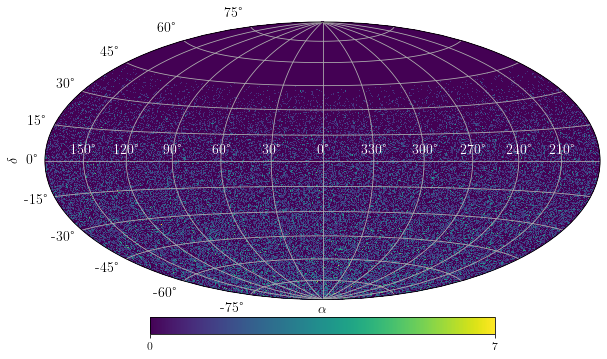

In [7]:
#loads the events from UD
file_path_scrab = './datasets/scrambled_events/' 
file_name_scrab = 'Scrambled_UniformDist_100000_acceptance_th80_2010-01-01_2020-01-01_9.parquet'

if not os.path.exists(file_path_scrab + file_name_scrab):
    print('File does not exist')
    exit()
    
#save events 
event_data = pd.read_parquet(file_path_scrab + file_name_scrab, engine='fastparquet')

#save declination and right ascension 
dec = np.radians(event_data['dec'].to_numpy())
ra = np.radians(event_data['ra'].to_numpy())

#deletes dataframe to save space in tmp memory 

del event_data 

#gets skymap of events
skymap = get_skymap(NSIDE, ra, dec)

#skymap = np.where(skymap > 25, skymap, 0)

#save figure
fig = plt.figure(figsize=(10,8)) #create figure

#plot sky map 
projview(
    skymap,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    #unit=r"$\log_{10}$ (Number of events)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white',
)


14


<Figure size 720x576 with 0 Axes>

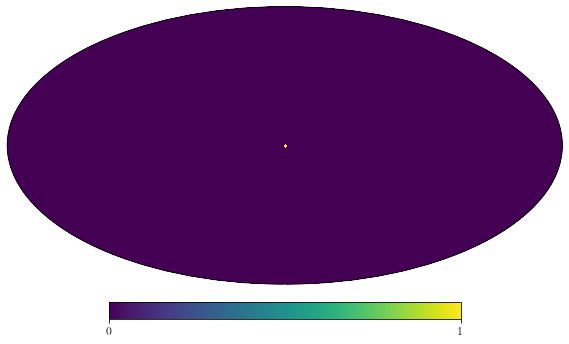

In [15]:
content = np.zeros(hp.nside2npix(NSIDE))

vec = hp.ang2vec(np.pi / 2, 0)
disc_pix = hp.query_disc(NSIDE, vec = vec, radius = np.radians(1))

print(len(disc_pix))

np.add.at(content, disc_pix, 1)

fig = plt.figure(figsize=(10,8)) #create figure

#plot sky map 
projview(
    content
)

In [41]:
x = np.array([[1, 2], [3, 4]])
y = np.array([1, 1, 1, 2, 3, 3, 4])

indices_array = []

for disc in x:
    indices = np.where(np.isin(y, disc))[0]
    indices_array.append(indices)

indices_array = np.array(indices_array, dtype=object)

dec = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

dec[indices_array]

event_number = list(map(len, indices_array))

print(event_number)

TypeError: only integer scalar arrays can be converted to a scalar index

In [51]:
a = [[2, 1, 4], [8, 1, 3, 5]]

b = np.sort(a[0])
print(b)
sorted_a = [np.sort(elem) for elem in a]

print(sorted_a)

[1 2 4]
[array([1, 2, 4]), array([1, 3, 5, 8])]
